In [ ]:
from matplotlib import pyplot as plt
import numpy as np
def rk4(h, y, inputs, f):
    '''
    用于数值积分的rk4函数。
    args:
        h - 步长
        y - 当前状态量
        inputs - 外界对系统的输入
        f - 常微分或偏微分方程
    return:
        y_new - 新的状态量,即经过h时间之后的状态量
    '''
    k1 = f(y, inputs)
    k2 = f(y + h / 2 * k1, inputs)
    k3 = f(y + h / 2 * k2, inputs)
    k4 = f(y + h * k3, inputs)

    y_new = y + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_new

def sigmoid(x):
    return 2 * (1 / (1 + np.exp(-(np.array(x)))) - 0.5)

stepNum = 500
start = 0
dt = .1
end = start + stepNum * dt
t = np.linspace(start, end, stepNum)
def myplot(t, listarray, label, linestyle='-'):
    plt.plot(t,listarray, label=label, linestyle=linestyle)
    plt.legend()

In [ ]:
class LowPassFilter:
    """
    current输入当前膜电位,
    history是current历史轨迹,注意历史轨迹初值应该等于当前,
    derivative()是history动力学方程,
    step()返回history,
    update()更新current,
    """
    def __init__(self, current=None, history=None, tau=0.1, dt=1) -> None:
        if current is not None:
            self.current = current
        else:
            assert current is not None, "The current is None."
        if history is None:            
            self.history = current
        else:
            self.history = history
        self.tau = tau
        self.dt = dt
        self.currentnew = self.current
        self.historynew = self.history
    
    def derivative(self, state, inputs=0):
        history = state
        Dhistory = self.tau * (self.current - history)
        return Dhistory

    def step(self, dt, current, inputs=0 ):
        """
        返回新的历史轨迹
        """
        if dt is None:
            dt = self.dt
        state = self.history
        self.current = current
        statenew = rk4(dt, state, inputs, self.derivative)
        self.historynew = statenew
        self.currentnew = self.current
        return statenew

    def update(self):
        self.current = self.currentnew
        self.history = self.historynew

In [ ]:
# 测试 LowPassFilter 
LPF = LowPassFilter(current=0)
curList, hisList = [], []
for i in t:
    if i < 200:
        cur = 0.5 * i / 100
    elif 200 <= i < 300 :
        cur = 0
    elif 300 <= i < 325:
        cur = 4 * (i - 300) / 100
    elif 325<= i < 400:
        cur = 1
    else:
        cur = 0
    curList.append(LPF.current)
    his = LPF.step(dt,cur)
    hisList.append(LPF.history)
    LPF.update()
myplot(t,curList,'cur')
myplot(t,hisList,'his')
plt.show()    

In [ ]:
# 测试 LowPassFilter 多维
LPF = LowPassFilter(current=np.array([0,0]))
curList, hisList = [], []
for i in t:
    if i < 200:
        cur = np.array([0.5 * i / 100, 0.5 * i / 100 *2])
    elif 200 <= i < 300 :
        cur = np.array([0, 0])
    elif 300 <= i < 325:
        cur = np.array([4 * (i - 300) / 100, 4 * (i - 300) / 100 *2])
    elif 325<= i < 400:
        cur = np.array([1, 2])
    else:
        cur = np.array([0, 0])

    curList.append(LPF.current)
    his = LPF.step(dt,cur)
    hisList.append(LPF.history)
    LPF.update()
myplot(t,curList,'cur')
myplot(t,hisList,'his')
plt.show()

In [ ]:
class Neuron:
    def __init__(self, num=3, I=0, potential=None, trajectory=None, tau=0.1, dt=1) -> None:
        """
        根据输入I,获取神经元激活的兴奋程度potential(兴奋当前1),
        trajectory(兴奋历史2)是potential的历史兴奋程度,
        delta(兴奋增量3)是兴奋当前-兴奋历史(1-2),
        updateDelta()更新delta,
        ,
        """
        self.num = num
        self.I = I
        assert self.num == np.size(I), "The input size is different from the neuron number."
        if potential is None:
            self.potential = self.activation(I)
        else:
            self.potential = potential
        if trajectory is None:
            self.trajectory = self.potential
        self.potentialnew = self.potential
        self.trajectorynew = self.trajectory
        self.delta = self.potential - self.trajectory        
        self.tau = tau
        self.dt = dt
        self.lowpassfilter = LowPassFilter(self.potential, self.trajectory, self.tau, self.dt)
    
    def updateDelta(self):
        self.delta = self.potential - self.trajectory 
        return self.delta
    
    def activation(self, I):
        return sigmoid(I)    
    """
    # def step(self, dt, inputs=0):
    #     if dt is None:
    #         dt = self.dt
    #     state = self.history
    #     statenew = rk4(dt, state, inputs, self.derivative)
    #     self.history = statenew
    #     return statenew
    """
    def step(self, dt, I):
        if dt is None:
            dt = self.dt
        assert self.num == np.size(I), "The input size is different from the neuron number."
        self.potential = self.activation(I)
        self.trajectory = self.potential
        self.trajectorynew = self.lowpassfilter.step(dt=dt, current=self.potential)
        self.potentialnew = self.potential
        return self.trajectorynew

    def update(self):
        self.potential = self.potentialnew
        self.trajectory = self.trajectorynew
        self.updateDelta()
        self.lowpassfilter.update()


In [ ]:
# 测试Neuron
num = 6
I = np.zeros(num).reshape(num,1)
KC = Neuron(num,I,tau=0.1,dt=dt)
plist, tlist = [], []
for i in t:
    if i < 200:
        I = np.array([[0.5 * i / 100, 0.5 * i / 100 *2, 1.5 * i / 100, 0.5 * i / 100 *4, 2.5 * i / 100, 0.5 * i / 100 *6]])
    elif 200 <= i < 300 :
        I = np.array([[0, 0, 0, 0, 0, 0]])
    elif 300 <= i < 325:
        I = np.array([[4 * (i - 300) / 100, 4 * (i - 300) / 100 *2, 4 * (i - 300) / 100, 4 * (i - 300) / 100 *2, 4 * (i - 300) / 100, 4 * (i - 300) / 100 *2]])
    elif 325<= i < 400:
        I = np.array([[1, 2, 3, 4, 5, 6]])
    else:
        I = np.array([[0, 0, 0, 0, 0, 0]])

    tra = KC.step(dt, I)
    plist.append(KC.potential[0])
    KC.update()
    tlist.append(KC.trajectory[0])
myplot(t, plist, 'pon')
myplot(t, tlist, 'tra', '--')
plt.show()

In [ ]:
class Synapse:
    def __init__(self, preNeuron: Neuron, postNeuron: Neuron, weight=None, reward=0, alpha=1, beta=1, dt=1, tau=1,) -> None:
        self.preNeuron = preNeuron
        self.postNeuron = postNeuron
        self.preNum = self.preNeuron.num
        self.postNum = self.postNeuron.num
        self.preI = self.preNeuron.I
        self.postI = self.postNeuron.I
        self.prePotential = self.preNeuron.potential
        self.prePotentialnew = self.prePotential
        self.preTrajectory = self.prePotential  # self.preNeuron.trajectory
        self.preTrajectorynew = self.preTrajectory
        self.postPotential = self.postNeuron.potential
        self.postPotentialnew = self.postPotential
        self.postTrajectory = self.postPotential  # self.preNeuron.trajectory
        self.postTrajectorynew = self.postTrajectory
        if weight is not None:
            self.weight = weight
        else:
            assert weight is not None, "The weight is None."
        assert self.weight.shape == (self.postNum, self.preNum), "The shape of the weight does not match. "
        self.reward = np.array(reward)
        self.alpha = alpha
        self.beta = beta
        self.dt = dt
        self.tau = tau

    def derivative(self, state, inputs=0):
        w = state
        Dw = (np.matmul(self.beta * np.tile(self.postTrajectory, self.postNum), (self.alpha * self.preTrajectory.T - w)) * self.reward) / self.tau
        return Dw

    def step(self, dt, preI, inputs=0):
        self.preI = preI
        if dt is None:
            dt = self.dt
        state = self.weight
        statenew = rk4(dt, state, inputs, self.derivative)
        self.weight = statenew
        self.preTrajectorynew = self.preNeuron.step(dt, self.preI)
        # self.postI = np.matmul(self.weight, self.prePotential)
        self.postI = np.matmul(self.weight, self.preNeuron.activation(self.preI))
        self.postTrajectorynew = self.postNeuron.step(dt, self.postI)
        return statenew

    def update(self):
        self.prePotential = self.preNeuron.potential
        self.preTrajectory = self.preTrajectorynew
        self.postPotential = self.postNeuron.potential
        self.postTrajectory = self.postTrajectorynew
        # self.preNeuron.potential = self.prePotentialnew
        # self.postNeuron.potential = self.postPotential
        self.preNeuron.update()
        self.postNeuron.update()

In [ ]:
class SynapseKM(Synapse):
    def __init__(self, preNeuron: Neuron, postNeuron: Neuron, weight=None, reward=0, alpha=1, beta=1, dt=1, tau=1) -> None:
        super().__init__(preNeuron, postNeuron, weight, reward, alpha, beta, dt, tau)
    
    def derivative(self, state, inputs=0):
        return super().derivative(state, inputs)

    def step(self, dt, preI, inputs=0):
        return super().step(dt, preI, inputs)
    
    def update(self):
        return super().update()

In [138]:
numKC, numMBON, numDAN = 6, 3, 3
stepNum = 5000
start = 0
dt = .01
end = start + stepNum * dt
t = np.linspace(start, end, stepNum)
def myplot(t, listarray, label, linestyle='-'):
    plt.plot(t,listarray, label=label, linestyle=linestyle)
    plt.legend()

dt: 0.1


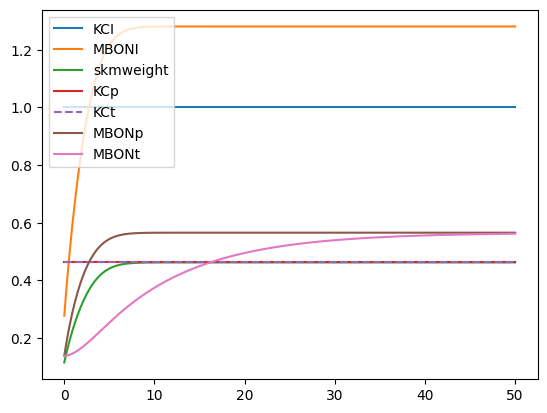

In [134]:
# 测试synapseKM
print('dt:',dt)
initWeightKM = np.ones([numMBON,numKC]) * .1
IKC = np.ones(numKC).reshape(numKC,1)
KC = Neuron(numKC,IKC,dt=dt)
IMBON = np.matmul(initWeightKM, KC.potential)
MBON = Neuron(numMBON,IMBON,dt=dt)

skm = SynapseKM(KC, MBON, initWeightKM, reward=1,dt=dt)
skmweight,KCp,KCt,MBONp,MBONt = [],[],[],[],[]
KCI, MBONI = [], []
for i in t:
    KCI.append(skm.preI[0][0])
    MBONI.append(skm.postI[0][0])
    KCp.append(skm.prePotential[0][0])
    KCt.append(skm.preTrajectory[0][0])
    MBONp.append(skm.postPotential[0][0])
    MBONt.append(skm.postTrajectory[0][0])
    KMWeight = skm.step(dt,np.ones(numKC).reshape(numKC,1))
    skm.update()
    skmweight.append(KMWeight[0][0])

myplot(t,KCI,label='KCI')
myplot(t,MBONI,label='MBONI')
myplot(t,skmweight, label='skmweight')
myplot(t,KCp, label='KCp')
myplot(t,KCt, label='KCt',linestyle='--')
myplot(t,MBONp, label='MBONp')
myplot(t,MBONt, label='MBONt')
plt.legend()
plt.show()


In [ ]:
class SynapseKD(Synapse):
    def __init__(self, preNeuron: Neuron, postNeuron: Neuron, weight=None, reward=0, alpha=1, beta=1, dt=1, tau=1) -> None:
        super().__init__(preNeuron, postNeuron, weight, reward, alpha, beta, dt, tau)
        self.delta = self.preNeuron.delta
    
    def derivative(self, state, inputs=0):
        w = state
        delta = self.delta
        Dw = (np.matmul(self.beta * np.tile(self.postPotential, self.postNum), (self.alpha * delta.T - w)) * self.reward) / self.tau
        return Dw

    def step(self, dt, preI, inputs=0):
        return super().step(dt, preI, inputs)
    
    def update(self):
        self.preNeuron.trajectory = self.preTrajectorynew
        self.delta = self.preNeuron.updateDelta()
        return super().update()

In [153]:
numKC, numMBON, numDAN = 6, 3, 3
stepNum = 500
start = 0
dt = .1
end = start + stepNum * dt
t = np.linspace(start, end, stepNum)
def myplot(t, listarray, label, linestyle='-'):
    plt.plot(t,listarray, label=label, linestyle=linestyle)
    plt.legend()

dt 0.1


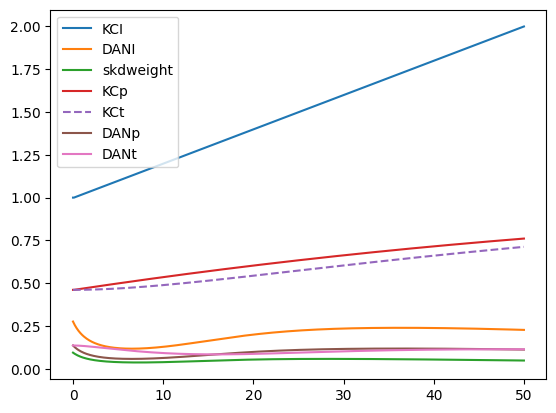

In [154]:
# 测试synapseKD
print('dt',dt)
initWeightKD = np.ones([numDAN,numKC]) * .1
IKC = np.ones(numKC).reshape(numKC,1)
KC = Neuron(numKC,IKC,dt=dt)
IDAN = np.matmul(initWeightKD, KC.potential)
DAN = Neuron(numDAN,IDAN,dt=dt)

skd = SynapseKD(KC, DAN, initWeightKD, reward=1, dt=dt)
skdweight,KCp,KCt,DANp,DANt = [],[],[],[],[]
KCI, DANI = [], []
for i in t:
    KCI.append(skd.preI[0][0])
    DANI.append(skd.postI[0][0])
    KCp.append(skd.prePotential[0][0])
    KCt.append(skd.preTrajectory[0][0])
    DANp.append(skd.postPotential[0][0])
    DANt.append(skd.postTrajectory[0][0])
    KDWeight = skd.step(dt,np.ones(numKC).reshape(numKC,1) + i/50)
    # KDWeight = skd.step(dt,np.ones(numKC).reshape(numKC,1))
    skd.update()
    skdweight.append(KDWeight[0][0])
    
myplot(t,KCI,'KCI')
myplot(t,DANI,'DANI')
myplot(t,skdweight,'skdweight')
myplot(t,KCp,'KCp')
myplot(t,KCt,'KCt','--')
myplot(t,DANp,'DANp')
myplot(t,DANt,'DANt')
plt.show()